In [2]:
import numpy as np
import pandas as pd

import cv2
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
torch.__version__, torchvision.__version__

('1.13.1+cu116', '0.14.1+cu116')

## Model

In [4]:
def double_convs(in_channels, out_channels):
    conv_layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same', bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),

        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same', bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

    return conv_layers

def expansion_block(upsample_layer, conv_layer, inp, concat_inp):
    mask = upsample_layer(inp)
    mask = torch.concat([concat_inp, mask], dim=1)
    mask = conv_layer(mask)

    return mask


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #contraction path
        self.contrac1 = double_convs(in_channels, 64)
        self.contrac2 = double_convs(64, 128)
        self.contrac3 = double_convs(128, 256)
        self.contrac4 = double_convs(256, 512)
        self.contrac5 = double_convs(512, 1024)

        #expansion path
        self.upsample1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.double_conv1 = double_convs(1024, 512)
        self.upsample2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.double_conv2 = double_convs(512, 256)
        self.upsample3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.double_conv3 = double_convs(256, 128)
        self.upsample4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.double_conv4 = double_convs(128, 64)

        #output layer
        self.out = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.Conv2d(64, out_channels, kernel_size=1)
            )

    def forward(self, image):
        #contraction
        cntrc_out1 = self.contrac1(image) #->
        out1 = self.max_pool(cntrc_out1)
        
        cntrc_out2 = self.contrac2(out1) #->
        out2 = self.max_pool(cntrc_out2)

        cntrc_out3 = self.contrac3(out2) #->
        out3 = self.max_pool(cntrc_out3)

        cntrc_out4 = self.contrac4(out3) #->
        out4 = self.max_pool(cntrc_out4)

        cntrc_out5 = self.contrac5(out4)

        #expansion
        mask = expansion_block(self.upsample1, self.double_conv1, cntrc_out5, cntrc_out4)
        mask = expansion_block(self.upsample2, self.double_conv2, mask, cntrc_out3)
        mask = expansion_block(self.upsample3, self.double_conv3, mask, cntrc_out2)
        mask = expansion_block(self.upsample4, self.double_conv4, mask, cntrc_out1)

        #output
        output = self.out(mask)

        return output

In [5]:
model = UNet(3, 22)

In [6]:
checkpoint = torch.load("../model/model.pt", map_location="cpu")
model_state = checkpoint['model_state_dict']

In [7]:
model.load_state_dict(model_state)

<All keys matched successfully>

## Loading Data

In [8]:
def transform_inputs(image_path, mask_path):
    transforms = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
    ])

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    trnsfrmd = transforms(image=image, mask=mask)

    image = trnsfrmd['image']
    mask = trnsfrmd['mask']
    
    return (image, mask)

In [9]:
def get_output(model, image):
    image = image.unsqueeze(0)
    
    logits = model(image.float())
    probs = logits.softmax(axis=1)
    probs = probs[0]
    pred = torch.argmax(probs, axis=0)
    pred *= 10
    pred_image = T.ToPILImage()(pred.float())
    
    return pred, pred_image

In [10]:
idx = 1

In [11]:
data = pd.read_csv('../dataset/preprocessed_data.csv')
mask_path = data.loc[idx, 'mask']
img_path = data.loc[idx, 'images']

In [12]:
image, mask = transform_inputs(img_path, mask_path)

In [13]:
pred_tnsr, pred = get_output(model, image)

## PREDICTED MASK

In [14]:
type(image.numpy())

numpy.ndarray

In [15]:
np_image = image.permute(1,2,0).numpy()
np_image.shape

(256, 256, 3)

In [16]:
np_mask = mask.numpy()
np_mask.shape

(256, 256)

In [17]:
np_pred = pred_tnsr.numpy()
np_pred.shape

(256, 256)

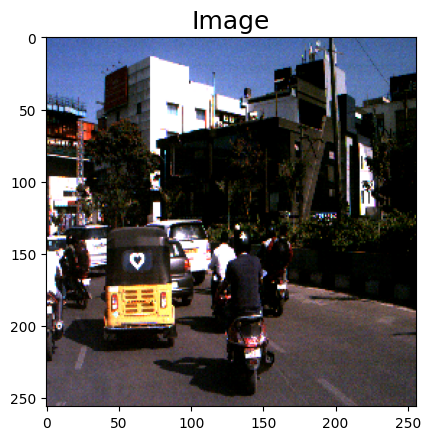

In [18]:
plt.title("Image",fontdict={'fontsize':18})
plt.imshow(np_image)
plt.show()

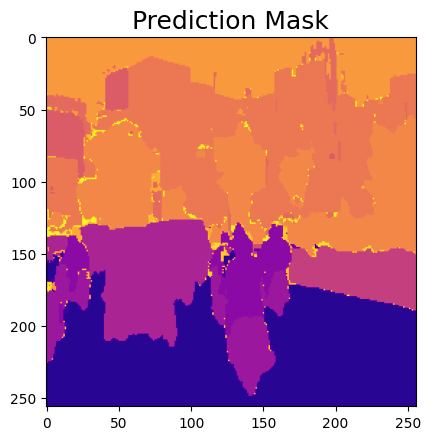

In [19]:
plt.title("Prediction Mask",fontdict={'fontsize':18})
rgb_np = plt.imshow(np_pred, cmap='plasma')
plt.show()

In [20]:
cm = plt.get_cmap('plasma')
colored_image = cm(np_pred)

In [21]:
type(colored_image)

numpy.ndarray

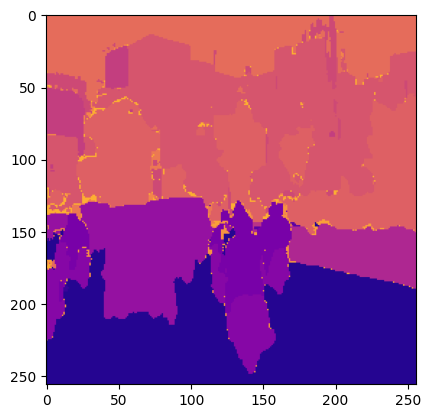

In [22]:
plt.imshow(colored_image)
plt.show()

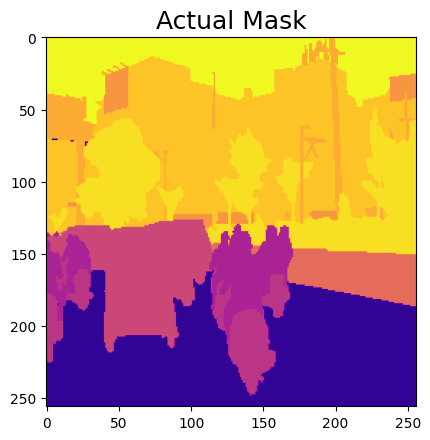

In [23]:
plt.title("Actual Mask",fontdict={'fontsize':18})
plt.imshow(np_mask, cmap='plasma')
plt.show()

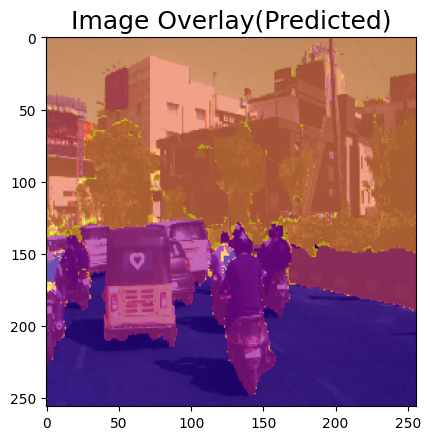

In [24]:
plt.title("Image Overlay(Predicted)",fontdict={'fontsize':18})
plt.imshow(np_image)
plt.imshow(np_pred, cmap='plasma', alpha=0.7)
plt.show()

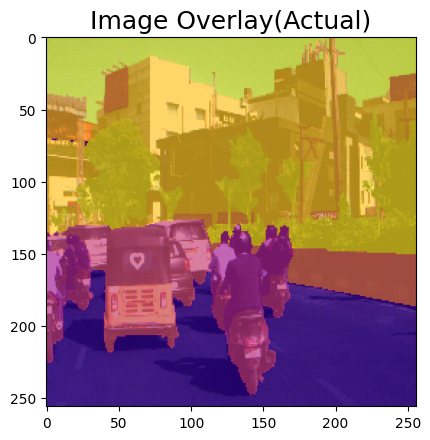

In [25]:
plt.title("Image Overlay(Actual)",fontdict={'fontsize':18})
plt.imshow(np_image)
plt.imshow(np_mask, cmap='plasma', alpha=0.7)
plt.show()

In [26]:
from matplotlib import cm

In [27]:
n_colors = 22
colours = cm.plasma(np.random.uniform(size = n_colors))

In [28]:
colours

array([[4.17642e-01, 5.64000e-04, 6.58390e-01, 1.00000e+00],
       [1.15124e-01, 2.35560e-02, 5.55468e-01, 1.00000e+00],
       [6.45872e-01, 1.20898e-01, 5.98867e-01, 1.00000e+00],
       [8.93250e-01, 4.11048e-01, 3.69768e-01, 1.00000e+00],
       [2.61183e-01, 1.33080e-02, 6.17911e-01, 1.00000e+00],
       [7.44232e-01, 2.18288e-01, 5.20524e-01, 1.00000e+00],
       [7.75796e-01, 2.53658e-01, 4.91171e-01, 1.00000e+00],
       [4.83210e-01, 8.46000e-03, 6.59095e-01, 1.00000e+00],
       [3.87183e-01, 1.43400e-03, 6.54177e-01, 1.00000e+00],
       [8.26588e-01, 3.15714e-01, 4.41316e-01, 1.00000e+00],
       [9.76428e-01, 5.96595e-01, 2.44767e-01, 1.00000e+00],
       [6.55580e-01, 1.29725e-01, 5.92317e-01, 1.00000e+00],
       [7.40143e-01, 2.13864e-01, 5.24216e-01, 1.00000e+00],
       [9.54287e-01, 9.34908e-01, 1.52921e-01, 1.00000e+00],
       [1.15124e-01, 2.35560e-02, 5.55468e-01, 1.00000e+00],
       [8.98984e-01, 4.20392e-01, 3.63047e-01, 1.00000e+00],
       [7.75796e-01, 2.5

In [29]:
from skimage import color
result_image = color.label2rgb(np_mask, np_image, colors=colours)

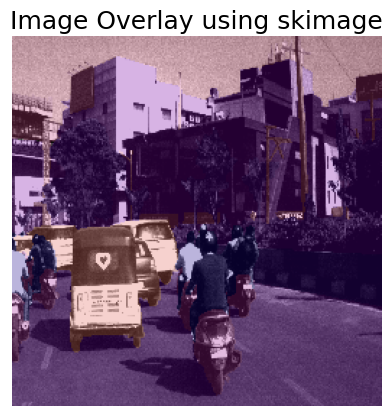

In [30]:
plt.title("Image Overlay using skimage", fontdict={'fontsize':18})
plt.imshow(result_image)
plt.axis('off')
plt.show()

In [31]:
result_image = color.label2rgb(np_pred, np_image, colors=colours)

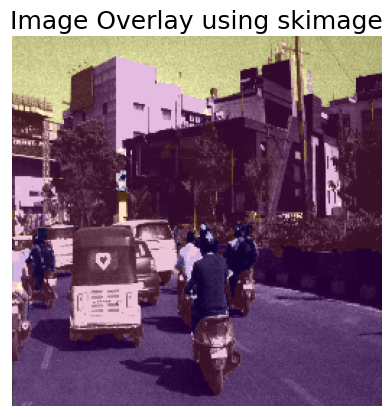

In [32]:
plt.title("Image Overlay using skimage", fontdict={'fontsize':18})
plt.imshow(result_image)
plt.axis('off')
plt.show()

In [33]:
result_image.max(), result_image.min()

(0.9929283999999999, 0.00016920000000000002)

In [52]:
result_image.dtype==np.float64

True

In [35]:
import io
import base64

In [46]:
def encode_arr(np_img):
    img = Image.fromarray((np_img*255).astype(np.uint8), 'RGB')
    buffered = io.BytesIO()
    img.save(buffered, format="JPEG")
    img_bytes = base64.b64encode(buffered.getvalue())

    img_string = img_bytes.decode()
    
    return img_string

In [47]:
def decode_data(encd_str):
    img = Image.open(io.BytesIO(base64.decodebytes(bytes(encd_str, "utf-8"))))
    
    np_arr = np.array(img)
    
    return np_arr   

In [48]:
img_str = encode_arr(result_image)

In [49]:
img_arr = decode_data(img_str)

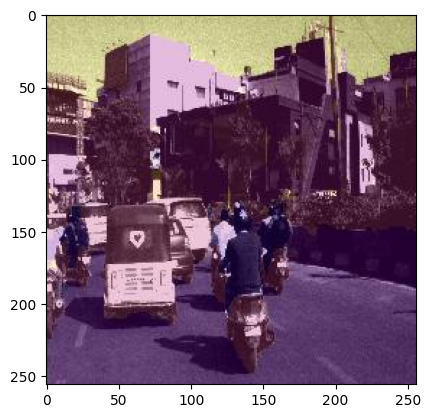

In [50]:
plt.imshow(img_arr)